In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
from tensorflow.keras.models import Model, Sequential
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


# Function to import dense VAE

In [2]:
batch_size = 100
original_dim = 64*64*6
latent_dim = 10
intermediate_dim = 2000
epochs = 150
epsilon_std = 1.0



############# VAE Convolutional model - Cyrille
# Parameters
input_shape = (64,64,6)
#original_dim = np.prod(input_shape)
latent_dim = 10
hidden_dim = 256
filters = [32,64, 128, 256]
kernels = [3,3,3,3]

def build_encoder(latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
    input_layer = Input(shape=(64,64,6))
    h = BatchNormalization()(input_layer)
    for i in range(len(filters)):
        h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
        h = PReLU()(h)
        h = Conv2D(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
        h = PReLU()(h)
    h = Flatten()(h)
    h = Dense(hidden_dim, activation=dense_activation)(h)
    h = PReLU()(h)
    mu = Dense(latent_dim)(h)
    sigma = Dense(latent_dim, activation='softplus')(h)
    return Model(input_layer, [mu, sigma])

encoder = build_encoder(latent_dim, hidden_dim, filters, kernels)

    # Def decoder
def build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation='softplus', dense_activation='softplus'):
    input_layer = Input(shape=(latent_dim,))
    h = Dense(hidden_dim, activation=dense_activation)(input_layer)
    h = PReLU()(h)
    w = int(np.ceil(input_shape[0]/2**(len(filters))))
    h = Dense(w*w*filters[-1], activation=dense_activation)(h)
    h = PReLU()(h)
    h = Reshape((w,w,filters[-1]))(h)
    for i in range(len(filters)-1,-1,-1):
        h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same', strides=(2,2))(h)
        h = PReLU()(h)
        h = Conv2DTranspose(filters[i], (kernels[i],kernels[i]), activation=conv_activation, padding='same')(h)
        h = PReLU()(h)
    h = Conv2D(input_shape[-1], (3,3), activation='sigmoid', padding='same')(h)
    cropping = int(h.get_shape()[1]-input_shape[0])
    if cropping>0:
        print('in cropping')
        if cropping % 2 == 0:
            h = Cropping2D(cropping/2)(h)
        else:
            h = Cropping2D(((cropping//2,cropping//2+1),(cropping//2,cropping//2+1)))(h)
    if (input_shape ==(64,64,1)):
        h = Reshape((64,64))(h)
        
    return Model(input_layer, h)

decoder = build_decoder(input_shape, latent_dim, hidden_dim, filters, kernels, conv_activation=None, dense_activation=None)

input_vae = Input(shape=(64,64,6))
output_encoder = encoder(input_vae)

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))(output_encoder)

vae = Model(input_vae, decoder(z))

def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim*K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))
    kl_loss = - .5 * K.get_value(alpha) * K.sum(1 + output_encoder[1] - K.square(output_encoder[0]) - K.exp(output_encoder[1]), axis=-1)
    return xent_loss + K.mean( kl_loss)

latest = tf.train.latest_checkpoint('/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v5/mse/')
vae.load_weights(latest)
#vae.load_weights('/pbs/home/b/barcelin/vae_conv_lsst_test_130000_200000_KL_reduced_test_300_noiseless')

Instructions for updating:
Colocations handled automatically by placer.

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7f9ac9c9e668> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9acb0d9710>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9acb0d9710> and <tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac9c9edd8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac9c9edd8> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ac9404d68>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ac9404d68> and <tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac936fb00>).

Two che


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f9ac9197f60> and <tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac9161a58>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac9161a58> and <tensorflow.python.keras.layers.core.Dense object at 0x7f9ac9197d30>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f9ac9197d30> and <tensorflow.python.keras.layers.core.Dense object at 0x7f9ac9126e48>).


In [3]:
# Deblender model
input_deblender = Input(shape=(64,64,6))

# Definition encoder
encoder_d = build_encoder(latent_dim, hidden_dim, filters, kernels)

output_encoder_d = encoder_d(input_deblender)
z_d = Lambda(sampling, output_shape=(latent_dim,))(output_encoder_d)

# Definition of deblender
deblender = Model(input_deblender, decoder(z_d))

def deblender_loss(x, x_decoded_mean):
    xent_loss = original_dim*K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))#metrics.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

#deblender.load_weights('/pbs/home/b/barcelin/deblender_conv_lsst_noisy')
latest = tf.train.latest_checkpoint('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v2/mse/')
deblender.load_weights(latest)

deblender.compile('adam', loss=deblender_loss, metrics=['mse'])


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization.BatchNormalizationV1 object at 0x7f9ac9c9e0f0> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ac9c9e048>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ac9c9e048> and <tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac80fd470>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac80fd470> and <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ac8179f60>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f9ac8179f60> and <tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac80c48d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.ker


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f9ac069cdd8> and <tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac061dba8>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.advanced_activations.PReLU object at 0x7f9ac061dba8> and <tensorflow.python.keras.layers.core.Dense object at 0x7f9ac061dbe0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.core.Dense object at 0x7f9ac061dbe0> and <tensorflow.python.keras.layers.core.Dense object at 0x7f9ac05ecba8>).


# Plot functions

In [4]:
def plot_rgb_lsst(ugrizy_img, ax=None):
    RGB_img = np.zeros((int(stamp_size/2),int(stamp_size/2),3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img)
    ugrizy_img = ugrizy_img[:,int(stamp_size/4):int(stamp_size*3/4),int(stamp_size/4):int(stamp_size*3/4)].reshape((6,int(stamp_size/2),int(stamp_size/2)))
    RGB_img[:,:,0] = ugrizy_img[1][:,:]
    RGB_img[:,:,1] = ugrizy_img[2][:,:]
    RGB_img[:,:,2] = ugrizy_img[4][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

In [5]:
def plot_rgb_lsst_euclid(ugrizy_img, ax=None):
    RGB_img = np.zeros((int(stamp_size/2),int(stamp_size/2),3))
    if ax is None:
        _, ax = plt.subplots(1,1)
    max_img = np.max(ugrizy_img[4:])
    ugrizy_img = ugrizy_img[:,int(stamp_size/4):int(stamp_size*3/4),int(stamp_size/4):int(stamp_size*3/4)].reshape(10,int(stamp_size/2),int(stamp_size/2))
    RGB_img[:,:,0] = ugrizy_img[5][:,:]
    RGB_img[:,:,1] = ugrizy_img[6][:,:]
    RGB_img[:,:,2] = ugrizy_img[8][:,:]
    ax.imshow(np.clip(RGB_img[:,:,[2,1,0]], a_min=0.0, a_max=None) / max_img)

# Ploting test

In [6]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

In [7]:
input_deblender.shape

TensorShape([Dimension(None), Dimension(64), Dimension(64), Dimension(6)])

# Batch generation

In [13]:
class BatchGenerator_lsst_process(keras.utils.Sequence):
    """
    Class to create batch generator for the LSST deblender
    """
    def __init__(self, list_of_samples,total_sample_size, batch_size, training_or_validation):
        """
        totat_sample_size: the total size of the sample which will be divided into batches
        batch_size: size of the batches
        list_of_samples: list of the differents numpy arrays containing the data 
        training_or_validation: choice for this generator: a training one will display the part of the data created for training (different from the validation one), and the validation one will display the part of the data for validation
        """
        self.total_sample_size = total_sample_size
        self.batch_size = batch_size
        self.list_of_samples = list_of_samples
        self.path = random.choice(self.list_of_samples)
        print(self.path)
        self.training_or_validation = training_or_validation
        
        self.x = np.empty([self.batch_size,6,64,64], dtype='float32')  
        self.y = np.empty([self.batch_size,6,64,64], dtype='float32')  
        
        self.liste = np.load(self.path, mmap_mode = 'c')
        self.r = 0
        
    def __len__(self):
        return int(float(self.total_sample_size) / float(self.batch_size))      

    def on_epoch_end(self):
        path = random.choice(self.list_of_samples)
        print(path)
        self.liste = np.load(path, mmap_mode = 'c')
        self.r = 0
        
    def __getitem__(self, idx):
        if (self.training_or_validation == 'training'):
            #print('training')
            self.r = np.random.choice(200-self.batch_size, replace=False)#1800
            if (self.r <=19900):
                #print('liste 1')
                self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
            else:
                if (self.r <=39900):
                    #print('liste 2')
                    self.r -= 20000
                    if (self.r >=100):
                        self.liste = np.load(self.list_of_samples[1], mmap_mode = 'c')
                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                    #self.j +=self.batch_size
                else:
                    if (self.r <=59900):
                        #print('liste 3')
                        self.r -= 40000
                        if (self.r >=100):
                            self.liste = np.load(self.list_of_samples[2], mmap_mode = 'c')
                            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                    else:
                        if (self.r <=79900):
                            self.r -= 60000
                            #print('liste 4')
                            if (self.r >=100):
                                self.liste = np.load(self.list_of_samples[3], mmap_mode = 'c')
                                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                        else:
                            if (self.r <=99900):
                                self.r -= 80000
                                #print('liste 5')
                                if (self.r >=100):
                                    self.liste = np.load(self.list_of_samples[4], mmap_mode = 'c')
                                    self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                    self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                            else:
                                if (self.r <=119900):
                                    self.r -= 100000
                                    #print('liste 5')
                                    if (self.r >=100):
                                        self.liste = np.load(self.list_of_samples[5], mmap_mode = 'c')
                                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                else:
                                    if (self.r <=139900):
                                        self.r -= 120000
                                        #print('liste 5')
                                        if (self.r >=100):
                                            self.liste = np.load(self.list_of_samples[6], mmap_mode = 'c')
                                            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                    else:
                                        if (self.r <=159900):
                                            self.r -= 140000
                                            #print('liste 5')
                                            if (self.r >=100):
                                                self.liste = np.load(self.list_of_samples[7], mmap_mode = 'c')
                                                self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                        else:
                                            if (self.r <=179900):
                                                self.r -= 160000
                                                #print('liste 5')
                                                if (self.r >=100):
                                                    self.liste = np.load(self.list_of_samples[8], mmap_mode = 'c')
                                                    self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                    self.y = self.liste[self.r:self.r+self.batch_size,0,4:]
                                            else:
                                                if (self.r <=189900):
                                                    self.r -= 180000
                                                    #print('liste 5')
                                                    if (self.r >=100):
                                                        self.liste = np.load(self.list_of_samples[9], mmap_mode = 'c')
                                                        self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
                                                        self.y = self.liste[self.r:self.r+self.batch_size,0,4:]


        else:
            self.r = np.random.choice(10000-self.batch_size, replace=False)
            self.liste = np.load(self.list_of_samples[0], mmap_mode = 'c')
            self.x = self.liste[self.r:self.r+self.batch_size,1,4:]
            self.y = self.liste[self.r:self.r+self.batch_size,0,4:]

        # Apply a random rotation to the galaxy to do data augmentation
        #random_degree = random.uniform(0, 180)
        #sk.transform.rotate(self.y, random_degree)
        
        #for i in range(10):
        I= [6.48221069e+05, 4.36202878e+05, 2.27700000e+05, 4.66676013e+04,2.91513800e+02, 2.64974100e+03, 4.66828170e+03, 5.79938030e+03,5.72952590e+03, 3.50687710e+03]
        beta = 1
        for i in range (100):
            for j in range (6):
                #print(4+j)
                self.y[i,j] = np.tanh(np.arcsinh(self.y[i,j]/(I[4+j]/beta)))
                self.x[i,j] = np.tanh(np.arcsinh(self.x[i,j]/(I[4+j]/beta)))
        # horizontal flip : flipping the image array of pixels
        rand = np.random.randint(2)
        #print(rand)
        if rand == 1: 
          #  print("oui")
            self.x = np.flipud(self.x)
            self.y = np.flipud(self.y)

        return self.x.reshape((self.batch_size,64,64,6)), self.y.reshape((self.batch_size,64,64,6))

In [32]:
list_of_samples = ['/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_0_v4.npy']

In [33]:
batch_gen = BatchGenerator_lsst_process(list_of_samples,total_sample_size=10000, batch_size= 100, training_or_validation = 'validation')

/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_0_v4.npy


In [30]:
test = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_v3.npy')

In [31]:
test.shape

(10000, 2, 10, 64, 64)

In [26]:
test = np.load("/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_0_v4.npy")

In [18]:
test.shape 

(200, 4)

In [19]:
test[0,1].shape

(10, 64, 64)

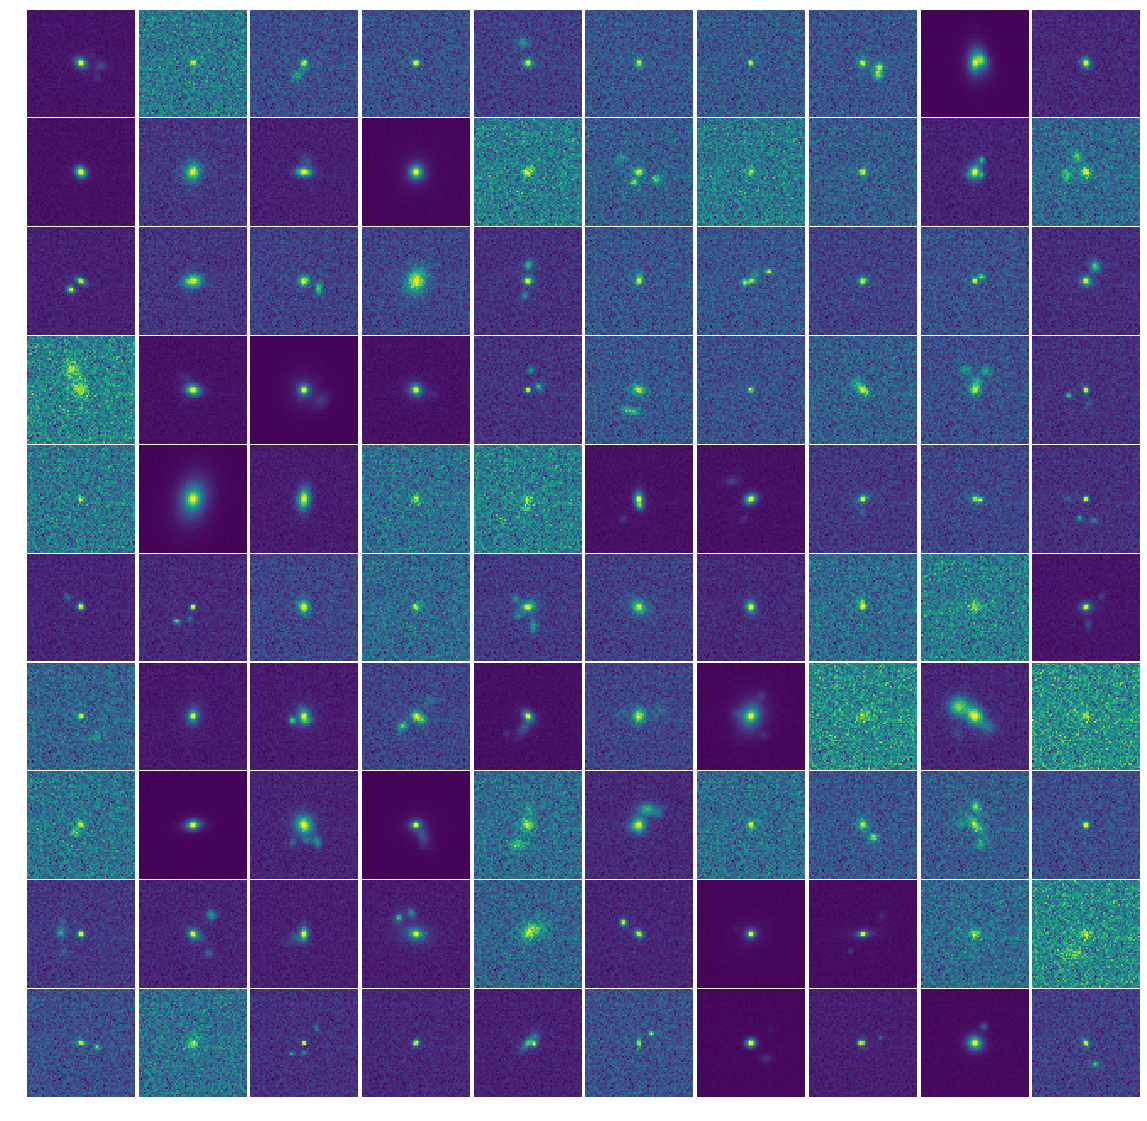

In [35]:
N_plot = 10
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        #print(i*N_plot+j)
        axes[i,j].imshow(test[i*N_plot+j][1][6])
        axes[i,j].axis('off')

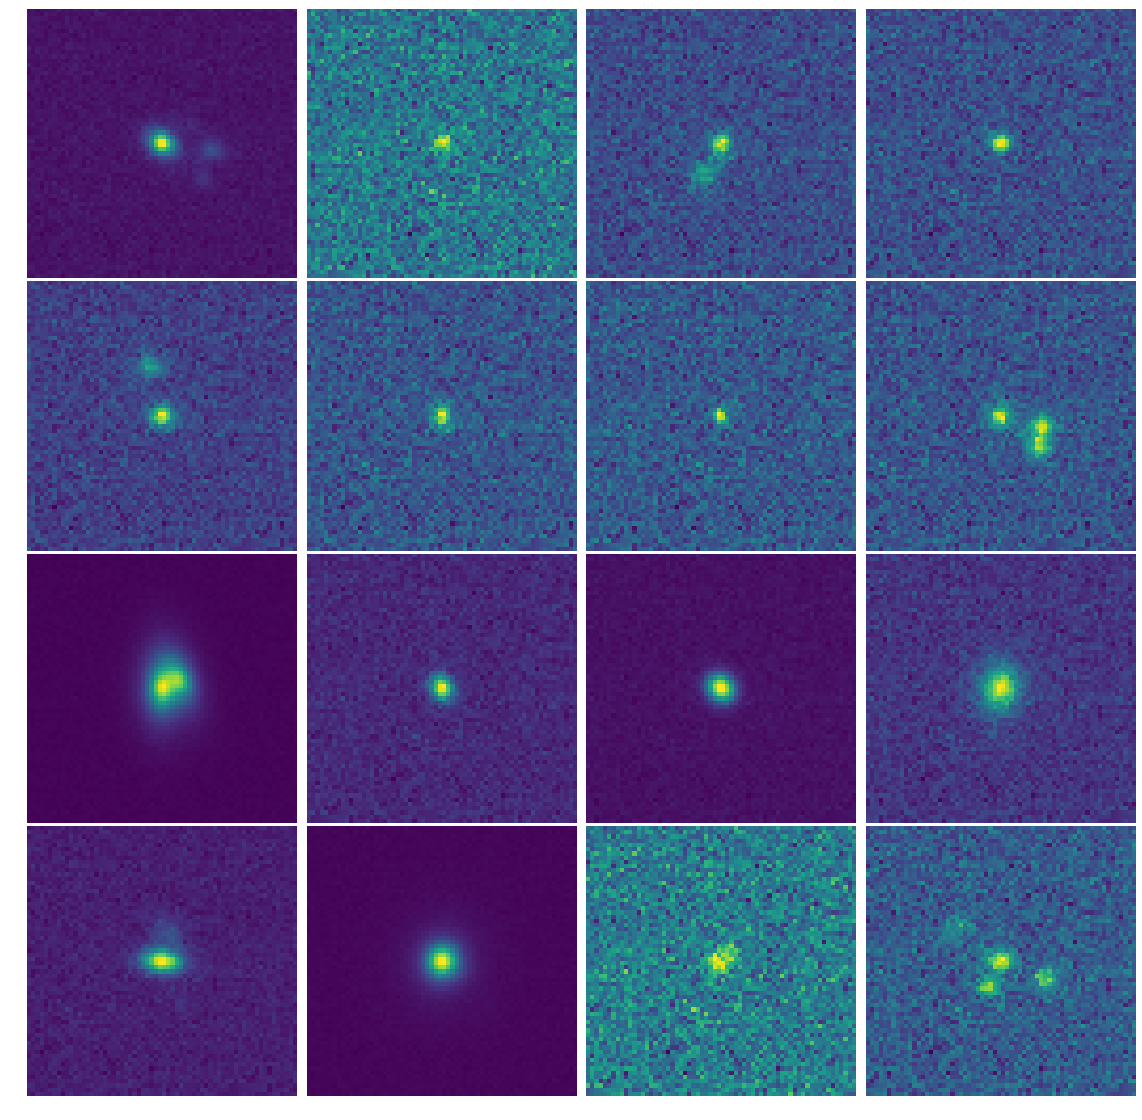

In [34]:
N_plot = 4
fig, axes = plt.subplots(N_plot, N_plot, figsize=(20, 20))
fig.subplots_adjust(wspace=.01, hspace=.01)

for i in range(N_plot):
    for j in range(N_plot):
        #print(i*N_plot+j)
        axes[i,j].imshow(test[i*N_plot+j][1][6])
        axes[i,j].axis('off')

# Mask function for flux computation

In [12]:
def createCircularMask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

## Test probleme de generation multiprocessed

In [13]:
blended_images = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_v3.npy')

In [7]:
blended_images.shape

(10000, 2, 10, 64, 64)

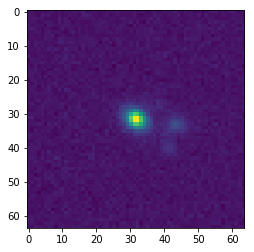

In [9]:
plt.imshow(blended_images[0][1][6])

In [13]:
lum_in_simple_gal = np.empty([10000,],dtype='float32')

for i in range (len(blended_images)):
    # Measurement of fluxes
    mask = createCircularMask(64,64,None,5)
    masked_img_in_simple = blended_images[i][0][6].copy()
    masked_img_in_simple[~mask] = 0  

    # Calculate the luminosity by substracting the noise
    lum_in_simple_gal[i] = np.sum(masked_img_in_simple)
    

In [33]:
gal_large_f_coord = np.where(lum_in_simple_gal[:]<1000000)

In [34]:
len(gal_large_f_coord[0])

9591

In [35]:
gal_large_f = np.delete(blended_images, gal_large_f_coord[0], axis = 0)

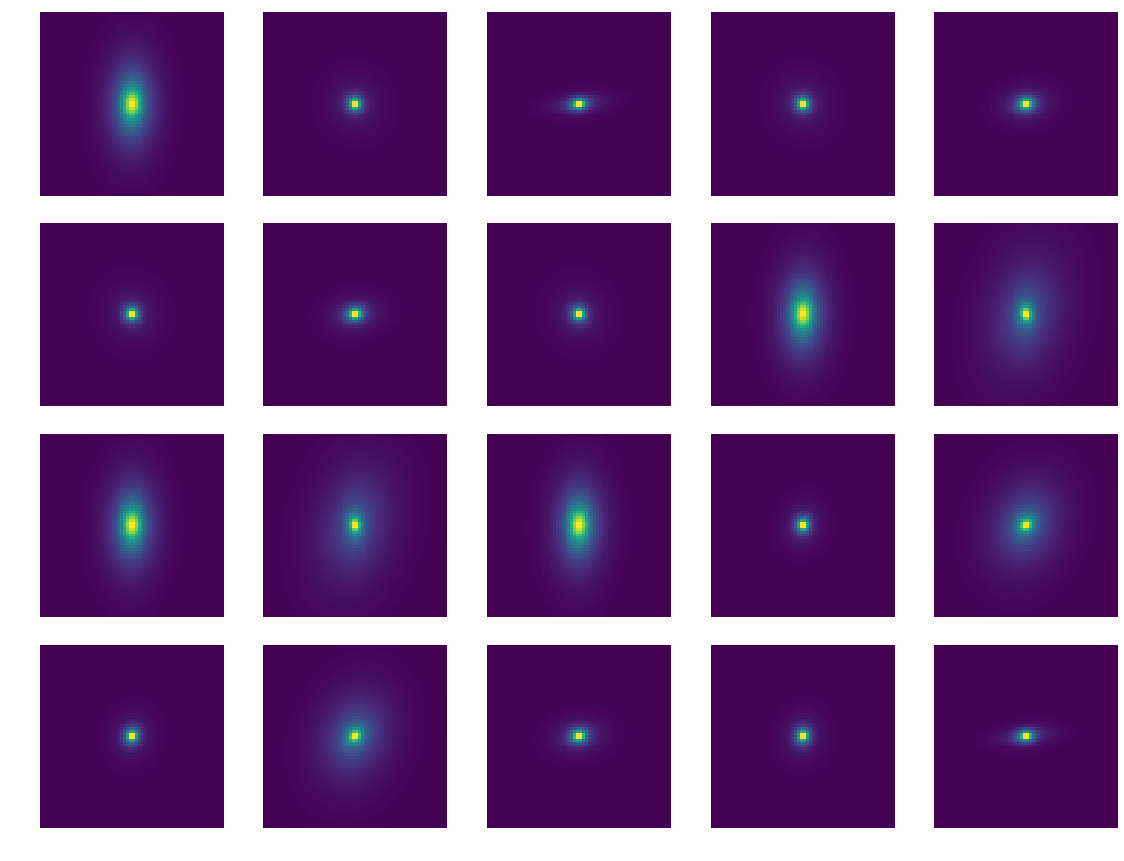

In [41]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)

N_plot = 3
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(20, size=20, replace=False)
#print(indices)
for i in range(4):
    for j in range(5):
        #print(gal_large_f[indices[i*N_plot+j]][0][6].shape)
        axes[i,j].imshow(gal_large_f[indices[i*N_plot+j]][0][3])
        axes[i,j].axis('off')

## LSST only

In [12]:
input_lsst = batch_gen.__getitem__(2)

In [13]:
input_lsst[0].shape

(100, 64, 64, 6)

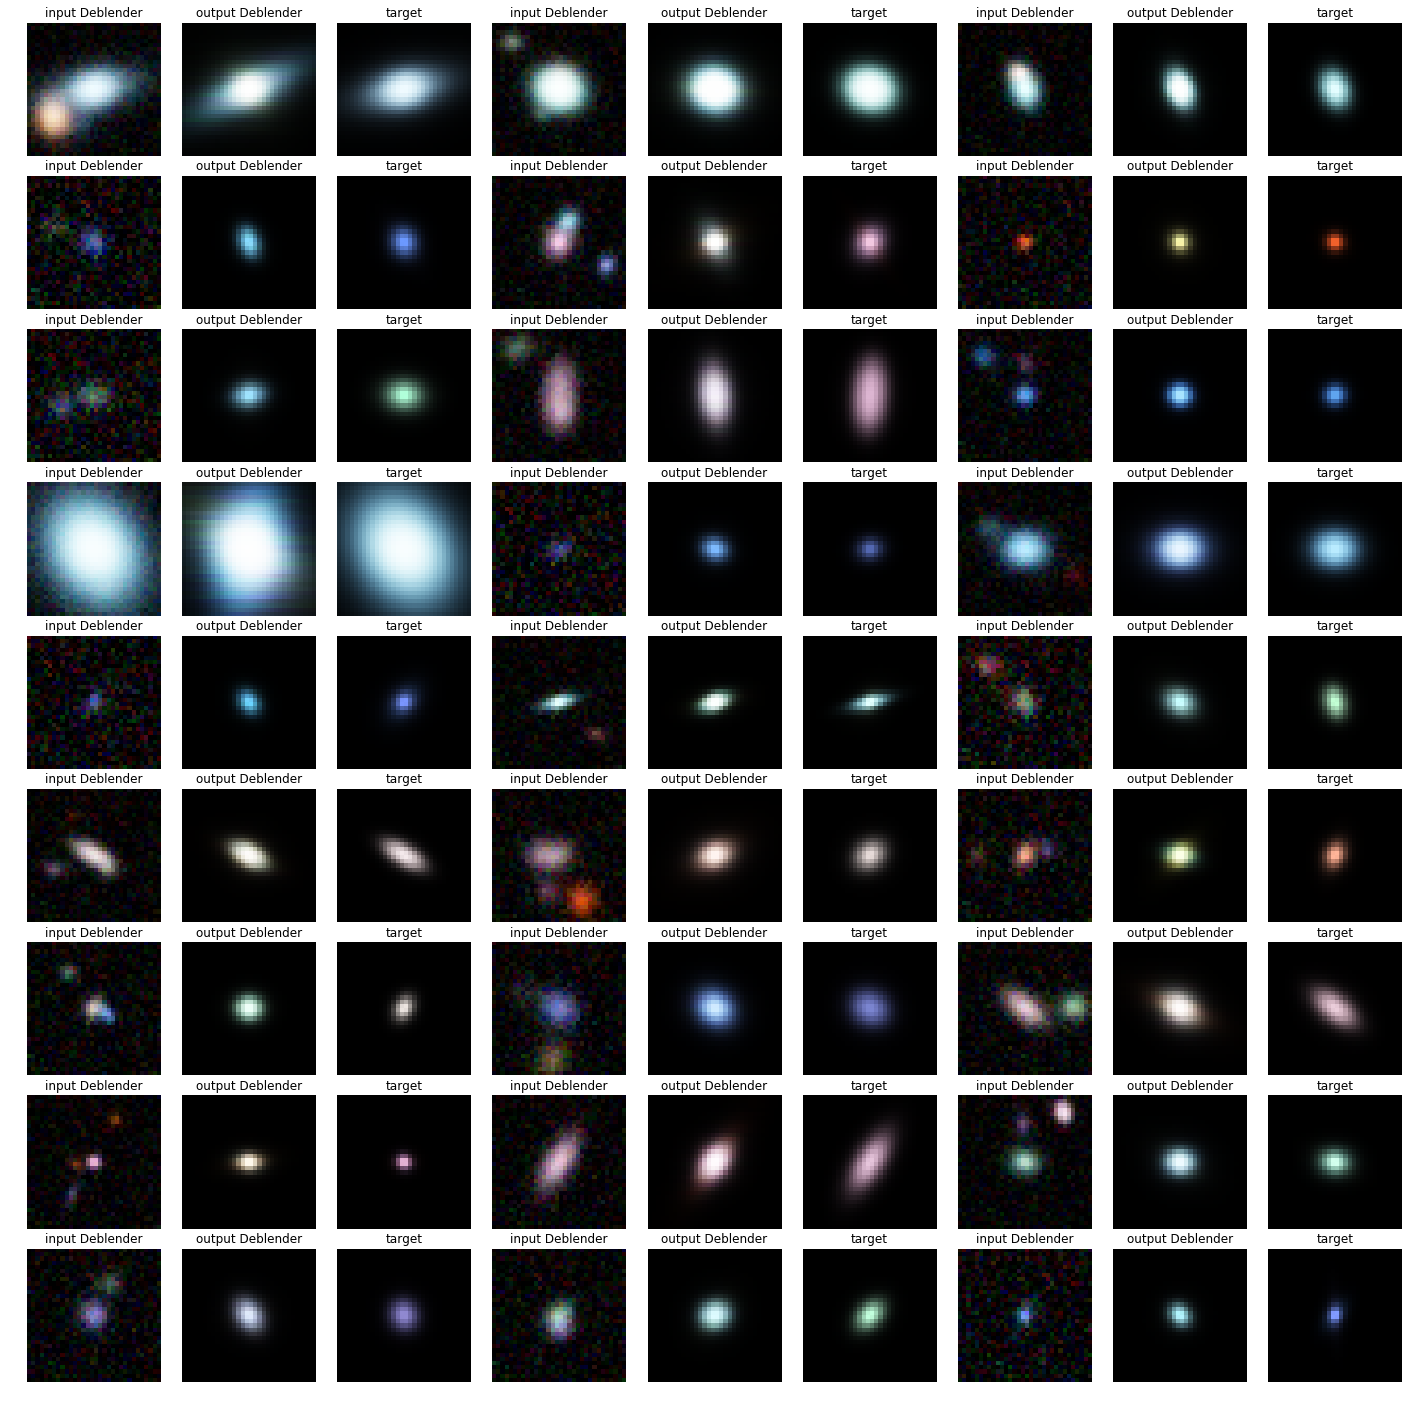

In [14]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
output_deblender_lsst = deblender.predict(input_lsst[0].reshape((100,64,64,6)), batch_size = 100)


for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_lsst[0][indices[i*N_plot+j]].reshape(6,64,64), axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]].reshape(6,64,64), axes[i,j+1])#output_vae
        plot_rgb_lsst(input_lsst[1][indices[i*N_plot+j]].reshape(6,64,64), axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Shape reproduction

In [15]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []

for j in range(100):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0], batch_size = batch_size)
    for i in range (len(a[0])):
        try: 
            gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]

            gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]

            ellipticities.append([e_in, e_out])

        except :
            print('erreur')
            pass
        continue

ellipticities_r_band = np.array(ellipticities)

erreur


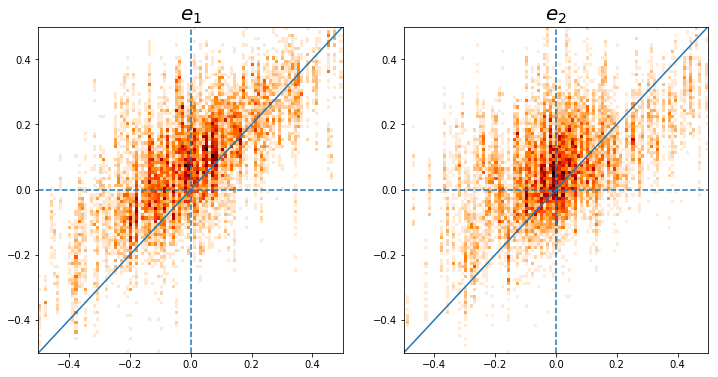

In [16]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 0.5
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    

# Load the shifts to evaluate the distance between 2 galaxies

In [55]:
shift = np.load('/sps/lsst/users/barcelin/data/blended/shift_val_v3_2.npy')

In [56]:
shift.shape

(10000, 4, 2)

In [59]:
def delta_r_min(shift_path):
    shift =np.load(shift_path)
    
    # set lists
    deltas_r= np.zeros((len(shift),4))
    delta_r= np.zeros((len(shift)))
    
    # compute the delta r for each couple of galaxies
    for i in range (4):
        deltas_r[:,i] = np.sqrt(np.square(shift[:,i,0])+np.square(shift[:,i,1]))

    # Take the min of the non zero delta r
    for j in range (len(shift)):
        if (deltas_r[j,:].any() == 0):
            delta_r[j] = 0
        else:
            x = np.where(deltas_r[j] == 0)[0]
            deltas = np.delete(deltas_r[j],x)
            delta_r[j] = np.min(deltas)
    
    return delta_r

In [60]:
delta_r = delta_r_min('/sps/lsst/users/barcelin/data/blended/shift_val_v3_2.npy')

In [28]:
#delta_r = np.sqrt(np.square(np.average(shift[:,:,0],axis =1))+np.square(np.average(shift[:,:,1],axis =1)))
#print(delta_r.shape)

(10000,)


# Compare deblender LSST vs LSST+Euclid

In [41]:
def compare_deblender(deb1, deb2,nb_1, nb_2, input_deb_1, input_deb_2, expected):
    ######
    # deb1, deb2 : the 2 deblenders which are being compared
    # nb_1, nb_2 : number of bands in the images processed respectively by deb1 and deb2
    # input_deb_1, input_deb_2 : the noisy blended images to process respectively for deb1 and deb2
    # expected: the noiseless centered galaxy images which are the targerts for the deblender 1
    ######
    # List of noisy blended images
    list_blended_1 = input_deb_1.reshape(len(input_deb_1),64,64,nb_1)
    list_blended_2 = input_deb_2.reshape(len(input_deb_2),64,64,nb_2)
    print(list_blended_1.shape)
    # List of noiseless centered galaxy
    list_simple = expected
    
    # Use deblenders on list of blended images
    list_output_1 = deb1.predict(list_blended_1, batch_size= 100)
    list_output_2 = deb2.predict(list_blended_2, batch_size= 100)
    
    # Reshape the lists so that it can be used for measurement
    list_output_1 = list_output_1.reshape(len(input_deb_1),nb_1,64,64)
    list_output_2 = list_output_2.reshape(len(input_deb_2),nb_2,64,64)
    print(list_output_1.shape)
    list_simple = list_simple.reshape(len(expected),nb_1,64,64)

    # Create empty lists for the futur measurements
    g_in = np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g1_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g2_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    
    g_out_1 = np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g1_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g2_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')

    g_out_2 = np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g1_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g2_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')

    err_count = 0
    for i in range (100):#len(input_deb_1)):
#        try :
        #print('image : '+str(i))
        # Add a PSF to be able to do an estimation of the shear
        PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
        final_epsf_image = PSF.drawImage(scale=0.2)

        # Define the images
        img_in = galsim.Image(list_simple[i,nb_1-4,16:48,16:48])
        #print(list_blended_1.shape)
        img_out_1 = galsim.Image(list_output_1[i,nb_1-4,16:48,16:48])
        img_out_2 = galsim.Image(list_output_2[i,nb_2-4,16:48,16:48])
        #print(list_output_1[i,nb_1-4,16:48,16:48].shape, str(nb_1-4))
        #print(list_output_2[i,nb_2-4,16:48,16:48].shape, str(nb_2-4))
        #plt.imshow(list_output_1[i,nb_1-4])
        # Measurements 
        ## for the input image
        g_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g
        #print(g_in[i])
        g1_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g1
        #print(g1_in[i])
        g2_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g2
        #print(g2_in[i])
        
        ## for the output image for the deblender deb1
        g_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g
        #print(g_out_1[i])
        g1_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g1
        #print(g1_out_1[i])
        g2_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g2
        #print(g2_out_1[i])
        ## for the output image for the deblender deb2
        g_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g
        #print(g_out_2[i])
        g1_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g1
        #print(g1_out_2[i])
        g2_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g2
        #print(g2_out_2[i])
#        except :
#            err_count +=1
#            print('erreur')
#            pass
#        continue
#    print(err_count)
    
    return g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2

In [42]:
g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2 = compare_deblender(deblender_lsst, deblender_lsst_euclid,6,10,input_deblender_lsst, input_deblender_lsst_euclid, input_deblender_no_noise_lsst)

(10000, 64, 64, 6)
(10000, 6, 64, 64)
image : 0
0.2082479
0.19913106
-0.060942654
0.036790792
0.034009717
-0.014032165
0.16499282
0.15605693
-0.0535618
image : 1
0.16798127
-0.026451362
0.1658856
0.15658477
-0.03602771
0.15238371
0.17420697
-0.019408643
0.17312242
image : 2
0.015851352
-0.0019065625
-0.015736276
0.08868295
-0.021780383
-0.085966736
0.02348353
-0.021882499
-0.008522464
image : 3
0.021669954
0.014525538
0.016080908
0.020390408
0.020253738
-0.002356865
0.03144208
0.021906106
0.022554975
image : 4
0.20160483
-0.0011992565
0.20160127
0.20832688
0.00688239
0.20821317
0.18581249
0.011259531
0.18547103
image : 5
0.23158796
-0.104689494
0.20657468
0.23533344
-0.12658247
0.19839028
0.2287074
-0.10791111
0.20164888
image : 6
0.11998794
-0.117808565
-0.022765057
0.07408505
-0.010791827
-0.07329482
0.10861742
-0.10680394
-0.01976517
image : 7
0.049526952
-0.0055145873
-0.049218982
0.04815506
0.0016616306
-0.04812638
0.06094573
-0.003158866
-0.06086381
image : 8
0.04619206
-0.017668

-0.12442082
0.10392915
0.04133713
-0.095354654
image : 74
0.11875908
0.112435594
0.03823554
0.12378496
0.122179255
0.01987324
0.08360412
0.076007724
0.034820616
image : 75
0.20552595
-0.003458937
-0.20549685
0.20924947
-0.036455277
-0.20604938
0.18458277
0.0022645297
-0.18456888
image : 76
0.13287856
-0.12798539
0.03572745
0.13762611
-0.13466565
0.02839205
0.14154579
-0.13268964
0.049281526
image : 77
0.12189686
0.05458897
0.10899032
0.04391239
0.040948823
0.015858488
0.12846608
0.053195484
0.11693492
image : 78
0.07118125
0.06414389
0.03085987
0.05739784
0.054537885
0.017892204
0.057015285
0.044195596
0.036020715
image : 79
0.3680707
0.28004238
0.23885626
0.36813596
0.26644644
0.25402832
0.36800182
0.25942957
0.2610012
image : 80
0.1587331
-0.07762931
-0.13845536
0.19166158
-0.09155821
-0.16837832
0.16123722
-0.09631994
-0.1293055
image : 81
0.05116644
-0.035789974
-0.036566135
0.052614756
0.0011119178
-0.052603006
0.037910182
0.0035725504
-0.03774147
image : 82
0.12260909
-0.06430983

In [43]:
# Calculate the differences from output measurement compared to input
## LSST
delta_g_lsst = g_in - g_out_1
delta_g1_lsst = g1_in- g1_out_1
delta_g2_lsst = g2_in-g2_out_1

## LSST + Euclid
delta_g_lsst_euclid = g_in - g_out_2
delta_g1_lsst_euclid = g1_in- g1_out_2
delta_g2_lsst_euclid = g2_in-g2_out_2


In [48]:
def mean_var(x,y,bins):

    n,_ = np.histogram(x,bins=bins, weights=None)
    ny,_ = np.histogram(x,bins=bins, weights=y)
    mean_y = ny/n
    ny2,_ = np.histogram(x,bins=bins, weights=y**2)
    var_y = (ny2/n - mean_y**2)/n
    
    return (mean_y, var_y)

The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


ValueError: weights should have the same shape as a.

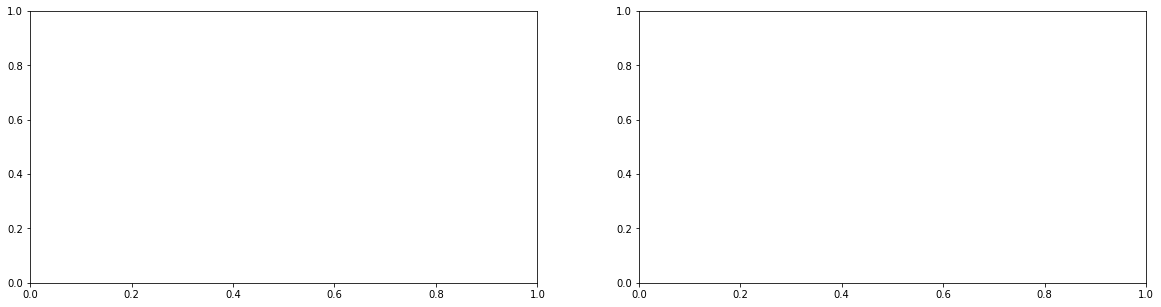

In [63]:
# Plot of the LSST and LSST+Euclid results comparison

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g, var_delta_g = mean_var(delta_r,delta_g_lsst_euclid,bins)
mean_delta_g1, var_delta_g1 = mean_var(delta_r,delta_g1_lsst_euclid,bins)
mean_delta_g2, var_delta_g2 = mean_var(delta_r,delta_g2_lsst_euclid,bins)

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r,delta_g2_lsst,bins)



ax = axes[0]
ax.plot(mid, mean_delta_g1, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g1 - 10*var_delta_g1**0.5, mean_delta_g1 + 10*var_delta_g1**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g2 - 10*var_delta_g2**0.5, mean_delta_g2 + 10*var_delta_g2**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

### Only the LSST results

In [ ]:
# Plot of the LSST results only

ig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r_2,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r_2,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r_2,delta_g2_lsst,bins)


#ax = axes[0]
#ax.plot(mid,mean_delta_g_lsst, label = 'LSST')
#ax.fill_between(mid, mean_delta_g_lsst - 10*var_delta_g_lsst**0.5, mean_delta_g_lsst + 10*var_delta_g_lsst**0.5, alpha=0.5)
#ax.set_ylabel('delta g', fontsize = 10)
#ax.set_xlabel('delta r', fontsize = 10)
#ax.legend(fontsize = 10)
#ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

ax = axes[0]
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)